# ZIF-FF Force Field Development

## Motivation

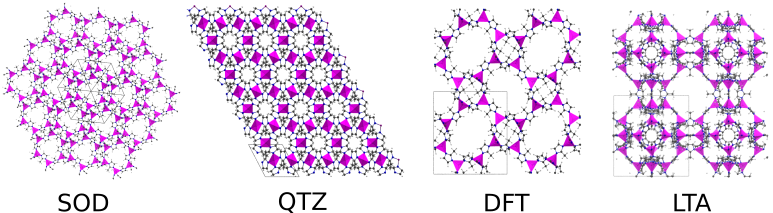

## Inter-molecular Force Field Optimization

In [ ]:
# Standard Packages
import numpy as np
import sys
import os
from scipy.optimize import minimize
from copy import copy
import sympy as sym
from sympy.utilities import lambdify
from sympy.utilities.iterables import flatten
import itertools

from force_field_fitting.fit_ff_parameters import FitFFParameters

###########################################################################
####################### Global Variables ##################################

################# Monomer names #################
mon1 = 'zif1'
mon2 = 'zif2'
################# Monomer names #################


################# Locations of input files #################
inputdir='./input/'
sapt_dir = inputdir
atomtypes_dir = inputdir
exponents_dir = inputdir
drudes_dir = inputdir
dispersion_dir = inputdir
multipoles_dir = inputdir
multipoles_suffix = '_ISA_L2.mom'
anisotropy_dir= inputdir
################# Locations of input files #################


################# Fit settings #################
fit_dispersion = True
fit_isotropic_dispersion = False

# Weighting function is defined by the Fermi-Dirac distribution and an
# Weighting function is defined by the Fermi-Dirac distribution and an
# effective fermi level and temperature. Here we keep the fermi level fixed at
# 0mH and modify the temperature to be half the absolute energy of the well-depth.
scale_weighting_temperature = 2.0

################# Fit settings #################



###########################################################################
###########################################################################


###########################################################################
###########################################################################

###########################################################################
def create_param_file(mon1,mon2,input_sapt, constraints, cn_coeffs,
                        drude_charges, outputfile, constrain_Aparams=True,
                        springcon=0.1):
    '''
    '''

    # Read in data from .bohr file. Geometry information has lines which each
    # contain exactly 4 blocks of information, allowing us to seperate out that
    # information based on that condition.
    with open(input_sapt,'r') as f:
        # First line contains information about the number of lines in monomer a
        num_atoms_mona=int(f.readline())
        count = 0
        geometry_block = []
        while count < 2:
            line = f.readline()
            if len(line.split()) != 4:
                count +=1
            else:
                geometry_block.append(line.split())

    # Use SAPT file to get an effective kt for fitting the data (1mH or less)
    with open(input_sapt,'r') as f:
        data = [line.split() for line in f.readlines()]

    etot_min = 0.0
    for i,line in enumerate(data):
        if len(line) > 0 and line[0] == 'E1tot+E2tot':
            etot = float(line[1]) + float(data[i+5][1])
            if etot < etot_min:
                etot_min = etot
    eff_kt = -etot_min/1000*scale_weighting_temperature


    # Use information from .bohr file to extract atom lists
    atom_list_mona=[line[0] for line in geometry_block[0:num_atoms_mona]]
    atom_list_monb=[line[0] for line in geometry_block[num_atoms_mona:]]

    # Order list of values for each atom
    params_mona = [ constraints[atom] for atom in atom_list_mona ]
    params_monb = [ constraints[atom] for atom in atom_list_monb ]


    # Write output param file
    with open(outputfile,'w') as f:
    
        # Settings
        f.write('SETTINGS\n')
        if fit_dispersion:
            f.write('fit_dispersion   True\n')
        if fit_isotropic_dispersion:
            f.write('fit_isotropic_dispersion   True\n')
        f.write('\n')
        
        # A coefficients
        f.write('LIST OF PARAMETER CONSTRAINTS\n')
        unique_atoms = set(atom_list_mona + atom_list_monb)
            
        f.write('EXCHANGE\n')
        if constrain_Aparams:
            #unique_atoms = set(atom_list_mona + atom_list_monb)
            for atom in unique_atoms:
                template='{:5s}'+'{:12.6f}\n'
                f.write(template.format(atom, constraints[atom][0]))
    
        f.write('ELECTROSTATICS\n')
        if constrain_Aparams: # No other aparams to write, aside from exchange
            for atom in unique_atoms:
                                                                                                                                            86,1          20%
        if constrain_Aparams: # No other aparams to write, aside from exchange
            for atom in unique_atoms:
                template='{:5s}\n'
                f.write(template.format(atom))

        f.write('INDUCTION\n')
        if constrain_Aparams: # No other aparams to write, aside from exchange
            for atom in unique_atoms:
                template='{:5s}\n'
                f.write(template.format(atom))

        f.write('DHF\n')
        if constrain_Aparams: # No other aparams to write, aside from exchange
            for atom in unique_atoms:
                template='{:5s}\n'
                f.write(template.format(atom))

        if fit_dispersion:
            f.write('DISPERSION\n')
            if constrain_Aparams: # No other aparams to write, aside from exchange
                for atom in unique_atoms:
                    template='{:5s}\n'
                    f.write(template.format(atom))

        # Anisotropic Atomtypes
        anisotropy_terms1, anisotropy_axes1 = get_anisotropy_terms(mon1)
        anisotropy_terms2, anisotropy_axes2 = get_anisotropy_terms(mon2)
        anisotropy_terms1.update(anisotropy_terms2)
        f.write('\nLIST OF ANISOTROPIC ATOMTYPES\n')
        for k, v in anisotropy_terms1.iteritems():
            template = '{:5s}'*(len(v)+1) + '\n'
            f.write(template.format(k,*v))
        f.write('\n')

        f.write('DEFINE COORDINATE AXES FOR EACH ANISOTROPIC ATOM IN EACH MONOMER\n')
        f.write('ATOM#   AXIS (z or x)   Atomic Indices defining vector (either 2 or 3 integers)\n')
        f.write('monomer 1\n')
        for line in anisotropy_axes1:
            template = '{:3s}'*(len(line)) + '\n'
            f.write(template.format(*line))
        f.write('monomer 2\n')
        for line in anisotropy_axes2:
            template = '{:3s}'*(len(line)) + '\n'
            f.write(template.format(*line))
           template = '{:3s}'*(len(line)) + '\n'
            f.write(template.format(*line))
        f.write('\n')
                
        # Exponents (B coefficients)
        f.write('EXPONENTS: One for each atom\n')
        for atom in unique_atoms:
            template='{:<5s}'+'{:10.6f}\n'
            f.write(template.format(atom, constraints[atom][1]))
        f.write('\n')

        # Dispersion (Cn coefficients)
        f.write(' Cn COEFFICIENTS (C6, C8, C10, C12)\n')
        for atom in unique_atoms:
            template='{:<5s}'+'{:16.6f}'*len(line) + '\n'
            f.write(template.format(atom,*cn_coeffs[atom]))
        f.write('\n')
        
        # Multipole file names
        f.write('MULTIPOLE FILES\n')
        f.write('monomer 1\n')
        multipole_file1 = mon1 + multipoles_suffix + '\n'
        f.write(multipole_file1)
        f.write('monomer 2\n')
        multipole_file2 = mon2 + multipoles_suffix + '\n'
        f.write(multipole_file2)
        f.write('\n')
        
        # Drude charges and spring coefficients
        f.write('DRUDE PARAMETERS (q   kx    ky    kz) \n')
        template='{:7s} {:10.6f} {:10.6f}{:10.6f}{:10.6f}\n'
        f.write('monomer 1\n')
        for i,line in enumerate(atom_list_mona):
            f.write(template.format(*drude_charges[0][i]))
        f.write('monomer 2\n')
        for i,line in enumerate(atom_list_monb):
            f.write(template.format(*drude_charges[1][i]))
        f.write('\n')
            
        # Fit Weights
        f.write('FITTING PARAMETERS\n')
        f.write('eff_mu(Ha)  0.000\n')
        f.write('eff_kT(Ha)  {:6.4f}\n'.format(eff_kt))
            


    return
###########################################################################


###########################################################################
def get_exponents(molecule,exponent_type='density-cutoff'):
    ''' Assuming exponent files of the following form (for each element in the
    file)

Atomtype:  C0
Fitting tail-corrected region using points over the range  1.84  to  6.34
B (two-point fit): 2.3864036044
B (average over range): 2.38639372601
B (r_abs_cutoff minimize RMSE): 2.38125128048
Fitting effective exponents using points over the range  1.14  to  8.72
B (density_abs_cutoff minimize RMSE): 2.38221095365

    extracts exponents for each atom in the molecule.

    Allowed exponent_type values are 'two-point', 'tail-average', and
    'density-cutoff'.
    '''

    # 7 lines per atom
    natomlines = 7

    if exponent_type == 'two-point':
        n_preskip_lines = 2
    elif exponent_type == 'tail-average':
        n_preskip_lines = 3
    elif exponent_type == 'density-cutoff':
        n_preskip_lines = 6
    else:
        sys.exit('Unrecognized exponent type.')

    with open(exponents_dir + molecule + '.exp','r') as f:
        data = [line.split() for line in f.readlines()]
        exponents = [float(i[-1]) for i in data[n_preskip_lines::natomlines] ]
                                                                                                                                            240,13        50%
    return exponents     
                                                                                                                                           127,9         30%
###########################################################################
########################## Main Code ######################################

pwd = os.getcwd()

# Make directory for the dimer pair
dimer_dir = mon1 + '_' + mon2 +'/'

# Copy relevant files for the dimer pair to the dimer directory
sapt_file = sapt_dir + mon1 + '_' + mon2 + '.sapt'
print sapt_file
subprocess.call(['cp', sapt_file, '.'])

# Change to the dimer directory, correct the sapt file
unconstrained_param_file = mon1 + '_' + mon2 + '_unconstrained.param'
sapt_file = mon1 + '_' + mon2 + '.sapt'

# Get exponents from the results of the ISA calculations
exponents_mon1 = get_exponents(mon1)
exponents_mon2 = get_exponents(mon2)

# No Aparams to speak of right now, so temporariliy set to 0
Aparams_mon1 = [ [0,i] for i in exponents_mon1]
Aparams_mon2 = [ [0,i] for i in exponents_mon2]

atomtypes_mon1 = [ line[0] for line in ReadCoordinates(atomtypes_dir + mon1 + '.xyz')[0] ]
atomtypes_mon2 = [ line[0] for line in ReadCoordinates(atomtypes_dir + mon2 + '.xyz')[0] ]

param_constraints = {}
all_atoms = atomtypes_mon1 + atomtypes_mon2
exponents = exponents_mon1 + exponents_mon2
unique_atoms = set(all_atoms)
# Get exponents for each monomer; in the case of conflicting exponents, take
# the average of all exponents for a given atomtype
for atom in unique_atoms:
    param_constraints[atom] = [0,
                        np.mean([exponents[i]
                        for i in range(len(all_atoms))
                        if all_atoms[i] == atom ])
                                ]

# Get drude charges from the results of the polarization calculations
drude_charges_mon1 = get_drude_charges(mon1)
drude_charges_mon2 = get_drude_charges(mon2)
drude_charges = [drude_charges_mon1, drude_charges_mon2]

# Get dispersion from the results of the dispersion calculations
dispersion_mon1 = get_dispersion_coeffs(mon1)
dispersion_mon2 = get_dispersion_coeffs(mon2)
dispersion = dispersion_mon1.copy()
dispersion.update(dispersion_mon2)

# Create the parameter file
create_param_file(mon1,mon2,sapt_file,param_constraints, dispersion,
        drude_charges, unconstrained_param_file, constrain_Aparams=False, springcon=0.1)
subprocess.call(['cp',multipoles_dir + mon1 + multipoles_suffix,'.'])
subprocess.call(['cp',multipoles_dir + mon2 + multipoles_suffix,'.'])

# Run the Force Field Fitting Program for each of the parameter files listed
# (to obtain 2 different fittings)
fitfiles = ['exchange','electrostatics','induction','dhf','dispersion','total_energy']

slater_fitfile = 'fit_exp_coeffs_unconstrained.out'
noslater_fitfile = 'constrained_exp_coeffs_unconstrained.out'

# Fitting with unconstrained Aii params and soft-constrained Bii params
FitFFParameters(sapt_file, unconstrained_param_file, slater_fitfile,\
        slater_correction=True, fit_bii=True,\
        aij_combination_rule='geometric_mean',\
        bij_combination_rule='geometric_mean')
for fitfile in fitfiles:
    subprocess.call(['mv', fitfile + '.dat', 'fit_exp_'+fitfile+'_unconstrained.dat'])

# Fitting with unconstrained Aii params and hard-constrained Bii params
FitFFParameters(sapt_file, unconstrained_param_file, noslater_fitfile,\
        slater_correction=True, fit_bii=False,\
        aij_combination_rule='geometric_mean',bij_combination_rule='geometric_mean')
for fitfile in fitfiles:
        aij_combination_rule='geometric_mean',bij_combination_rule='geometric_mean')
for fitfile in fitfiles:
    subprocess.call(['mv', fitfile + '.dat', 'constrained_exp_'+fitfile+'_unconstrained.dat'])
                        
# Change back to the home directory
os.chdir(pwd)                   

                                                                                                                                                                                                                       43,0-1        10%
                                                                                                   128,1          3%

                                                                                                                                            43,5           1%


## Intra-molecular Force Field Optimization

In [1]:
#evolving the population
def main():
    random.seed(60)

    pop = toolbox.population(n=40)
    CXPB, MUTPB, NGEN = 0.85, 0.05, 5

    print("Start of evolution")

    # Evaluate the entire population
    fitnesses=[]
    for ind in pop:
        fitnesses.append(toolbox.evaluate(ind))

    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(pop))

    # Begin the evolution
    for g in range(NGEN):
        print("-- Generation %i --" % g)

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = []
        for ind in invalid_ind:
            fitnesses.append(toolbox.evaluate(ind))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print("  Evaluated %i individuals" % len(invalid_ind))

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        print("  Statistics:   Min   Max   Avg  Std ")
        opt=['strain','scaledxyz','cell']
        for oi in range(3):
            fits = [ind.fitness.values[oi] for ind in pop]
            length = len(pop)
            mean = sum(fits) / length
            sum2 = sum(x*x for x in fits)
            std = abs(sum2 / length - mean**2)**0.5
            print("Fitness: %s, %s, %s, %s, %s" % (opt[oi],min(fits), max(fits), mean, std))


    print("-- End of (successful) evolution --")

    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    create_input_file(best_ind)

## KNN Classifier 

In [ ]:
import json
import numpy as np
import sys
from common import *

def main():
    k_param = int(sys.argv[1])
    trainingfile = sys.argv[2]
    testfile = sys.argv[3]
    #load training and test data
    label_list, training_numeric, training_categorical, training_labels = load_data(trainingfile)
    #print(label_list)
    test_label, test_numeric, test_categorical, test_labels = load_data(testfile)
    if np.size(training_numeric)!=0:
        #standardize training data
        training_mu, training_sigma = standard_values(training_numeric)
        #print(training_mu, training_sigma)
        training_numeric_d = get_standardize(training_numeric, training_mu, training_sigma)
        test_numeric_d = get_standardize(test_numeric, training_mu, training_sigma)
    else:
        training_numeric_d = training_numeric
        test_numeric_d = test_numeric

    for itest in range(len(test_labels)):
        predict_knn = knn_neighbors(k_param,test_numeric_d[itest],test_categorical[itest],training_numeric_d,training_categorical, training_labels)
        #predict_knn = knn_neighbors(k_param,test_numeric[itest],test_categorical[itest],training_numeric,training_categorical, training_labels)
        label_votes,predict_label = getlabel_votes(predict_knn,label_list)
        predict_votes_label = label_votes.tolist()
        predict_votes_label.append(predict_label)
        print(*predict_votes_label,sep=',')


## Results 

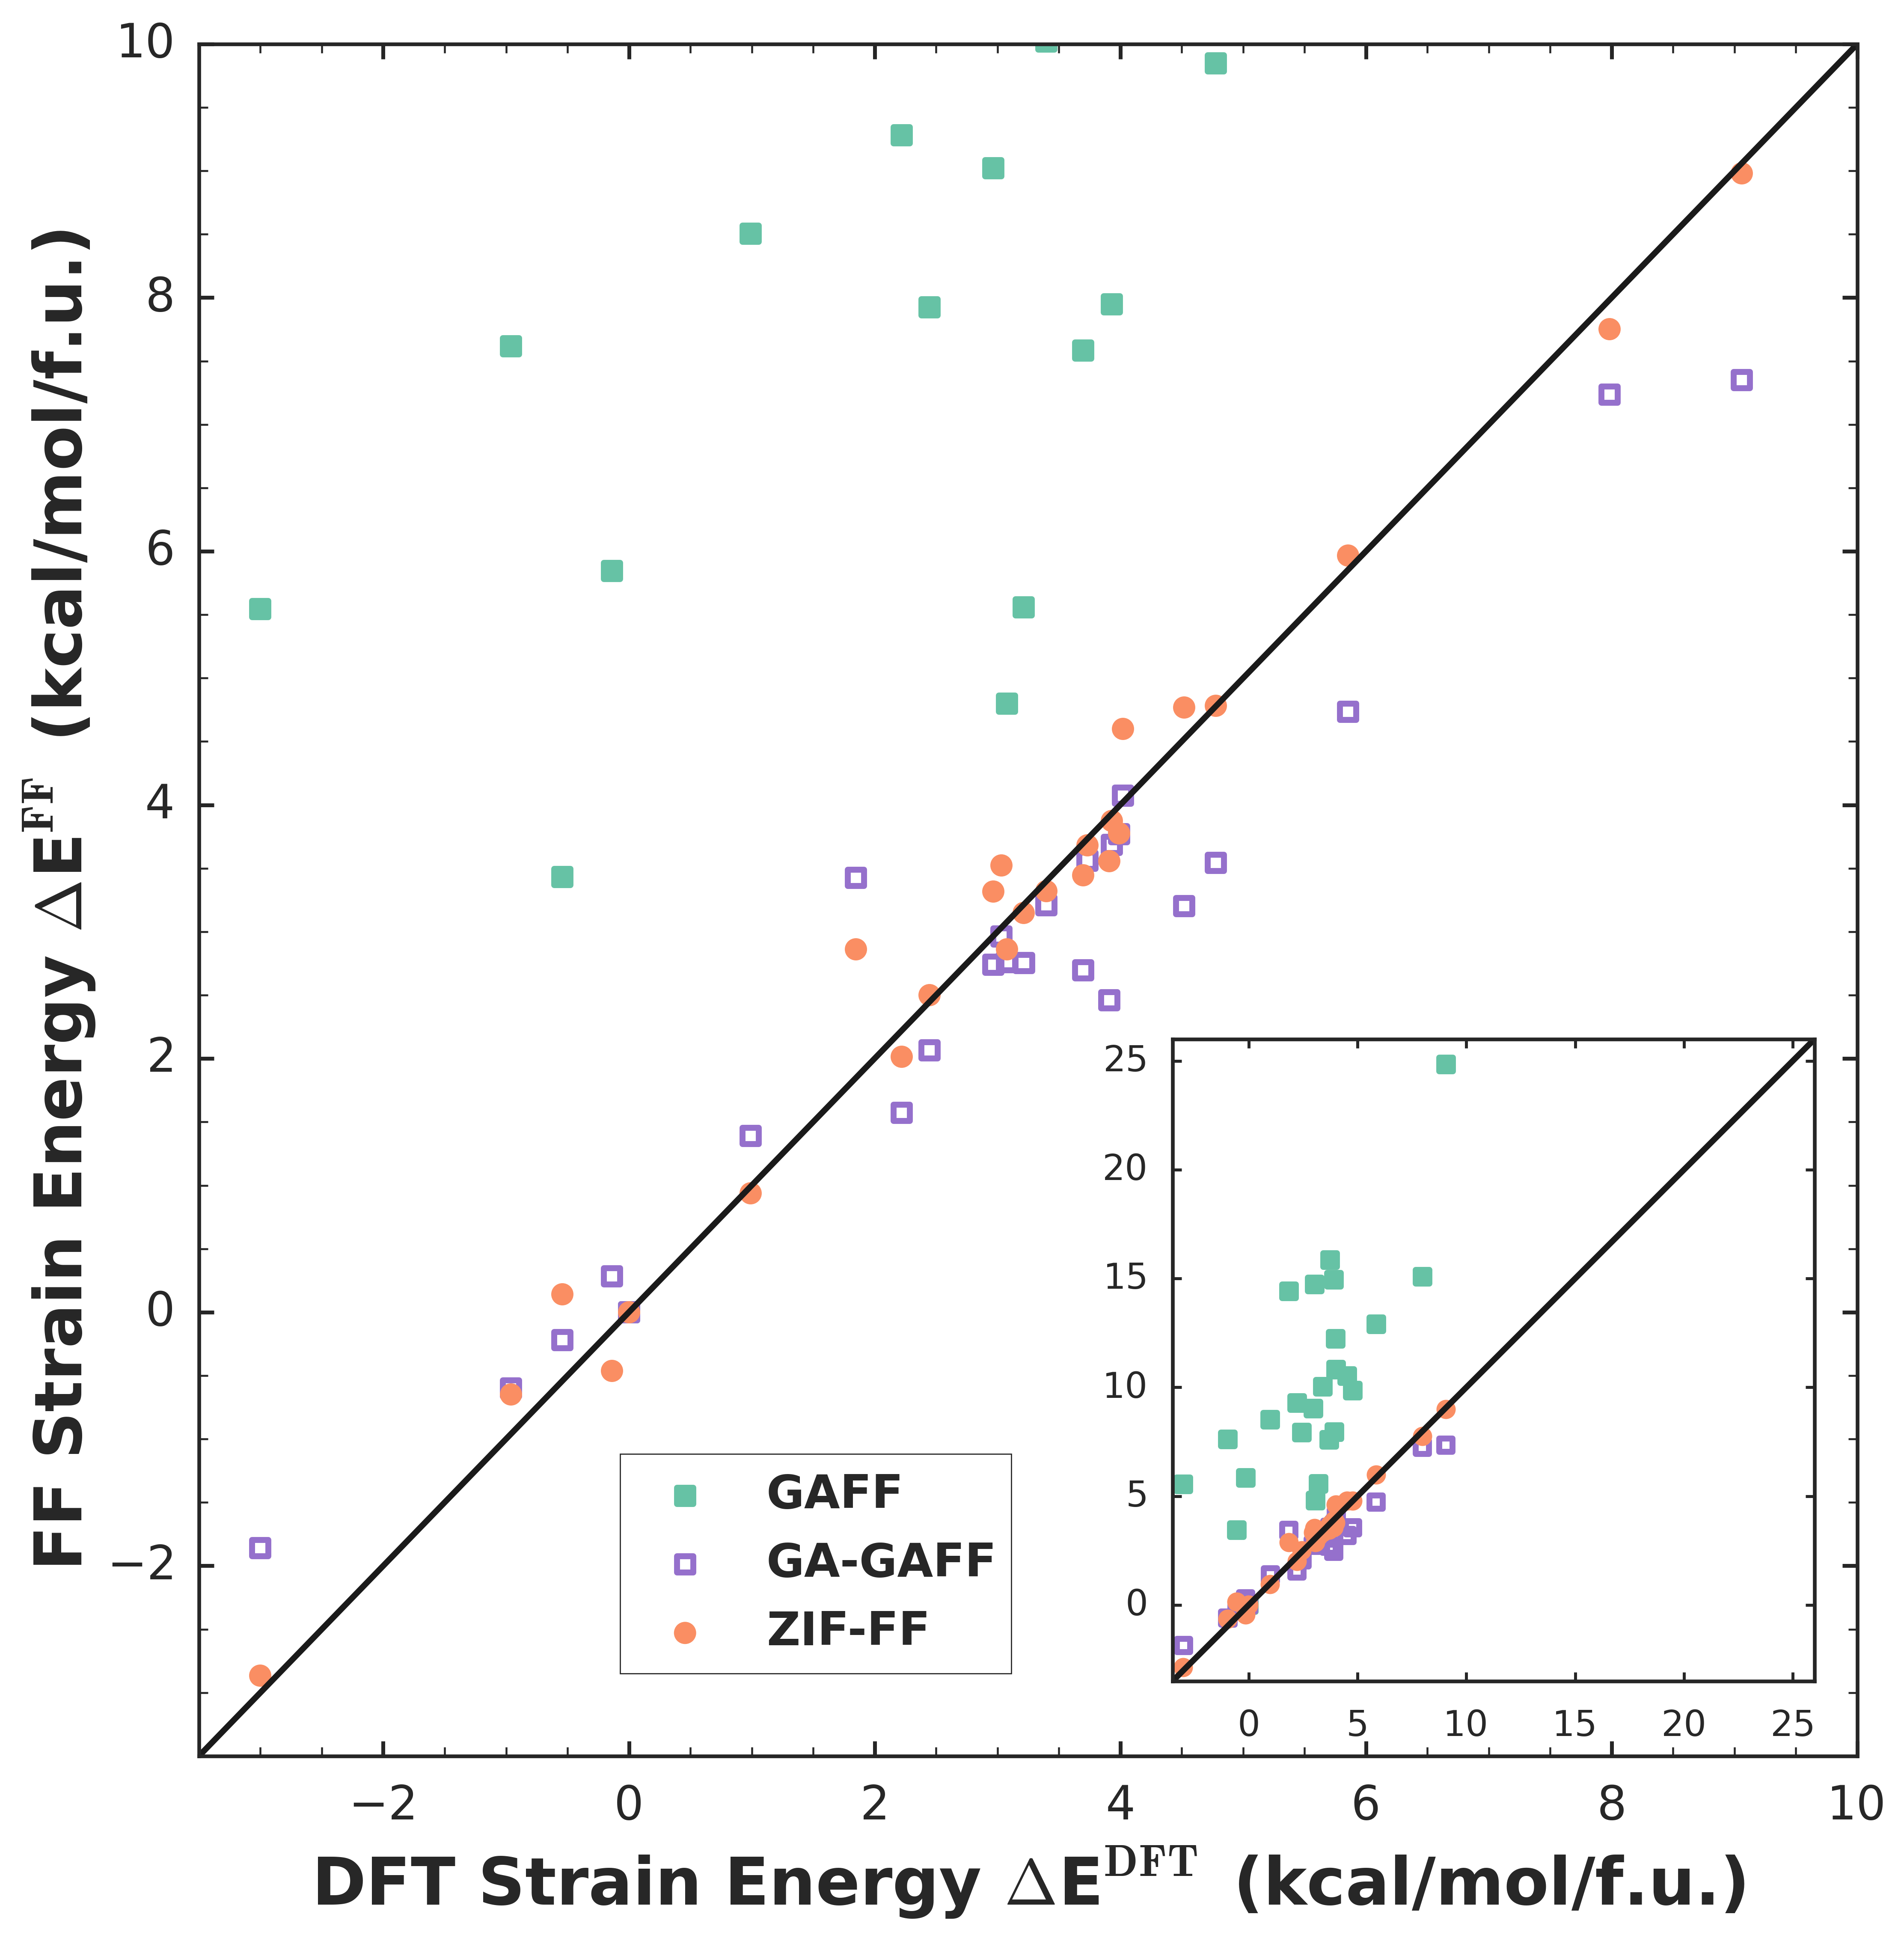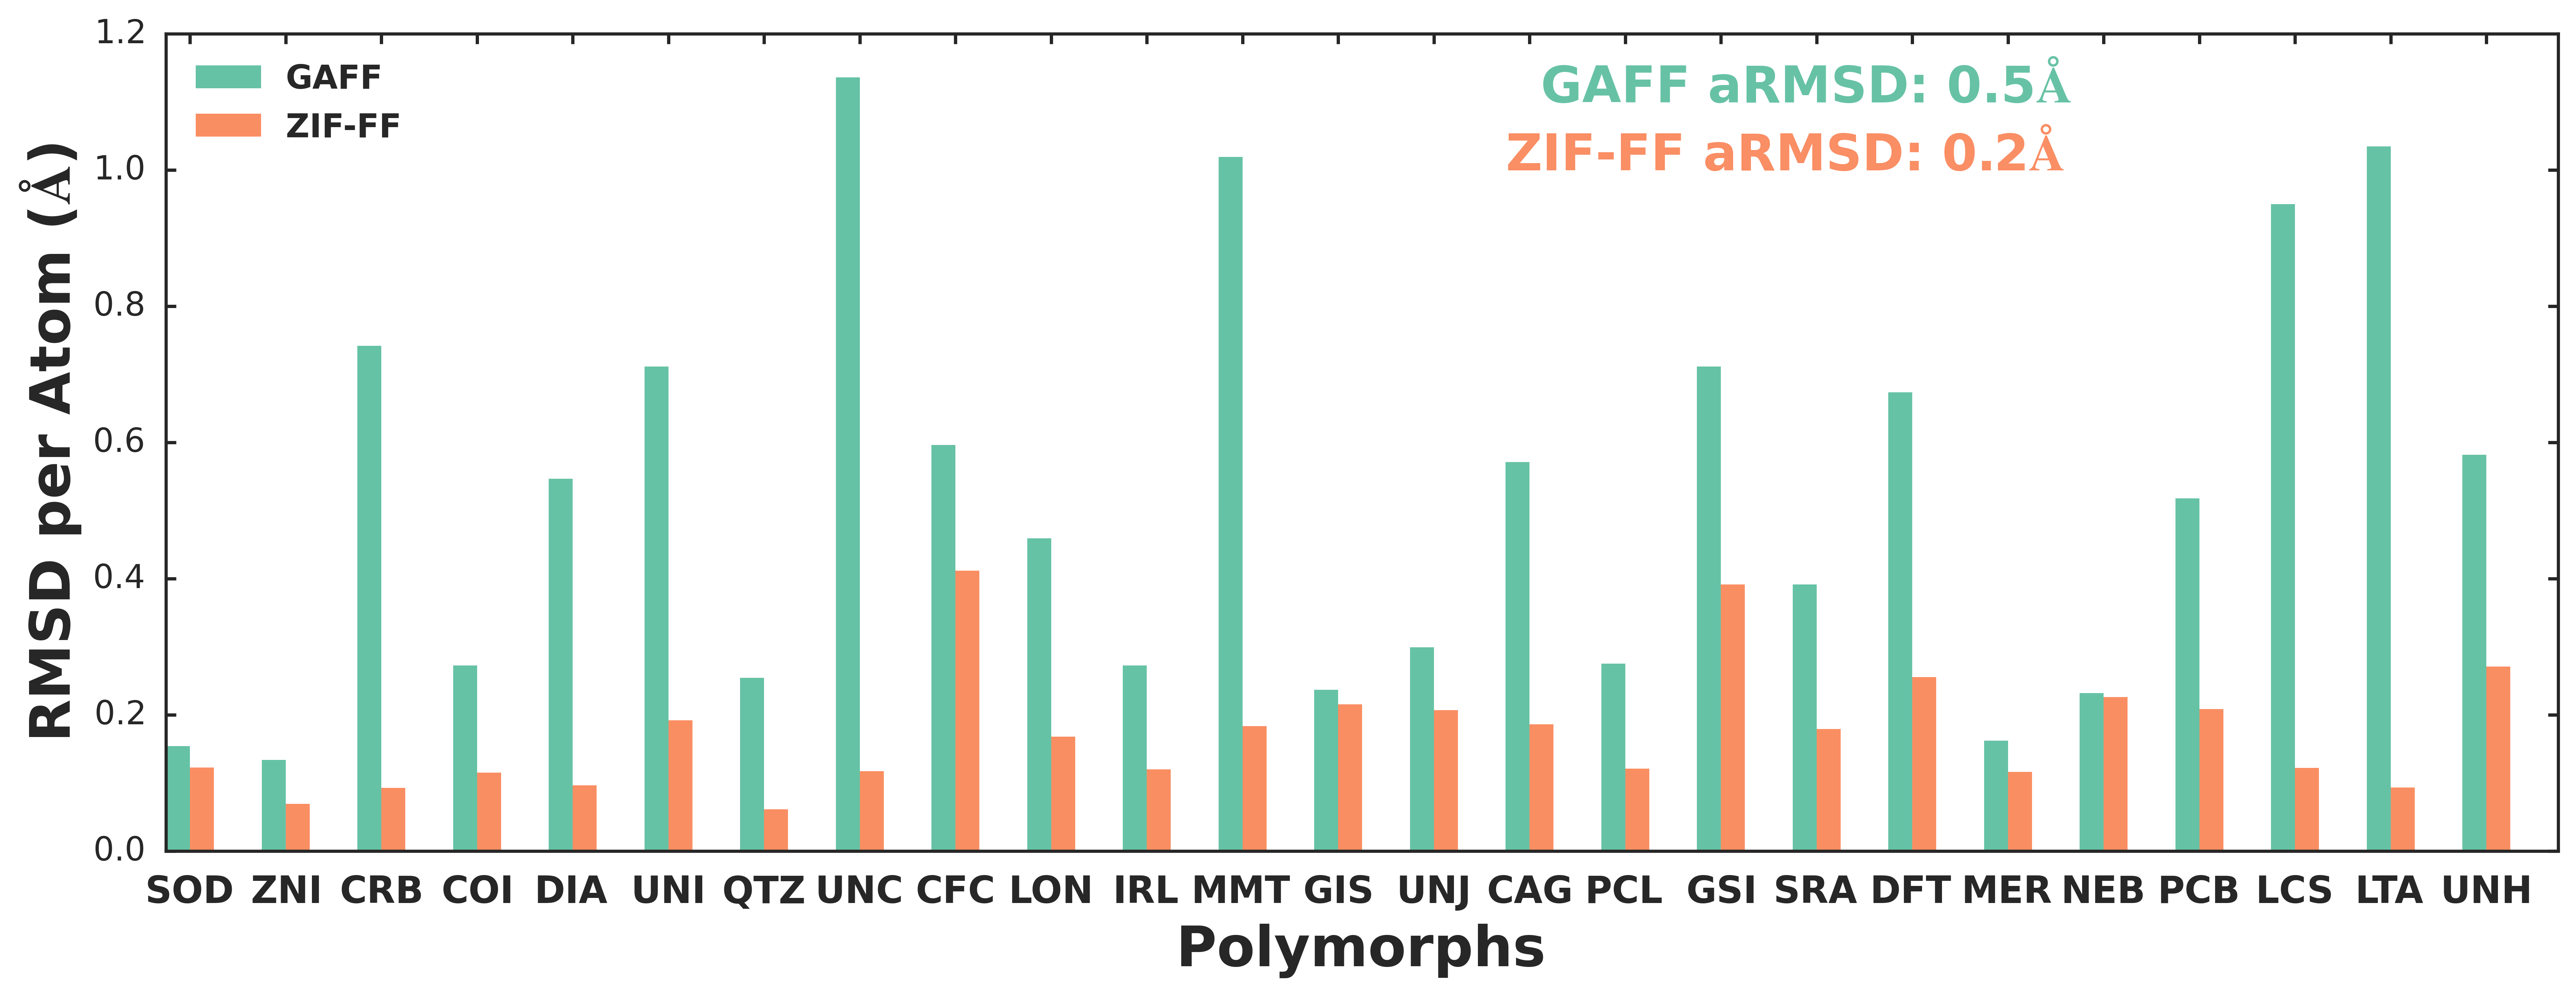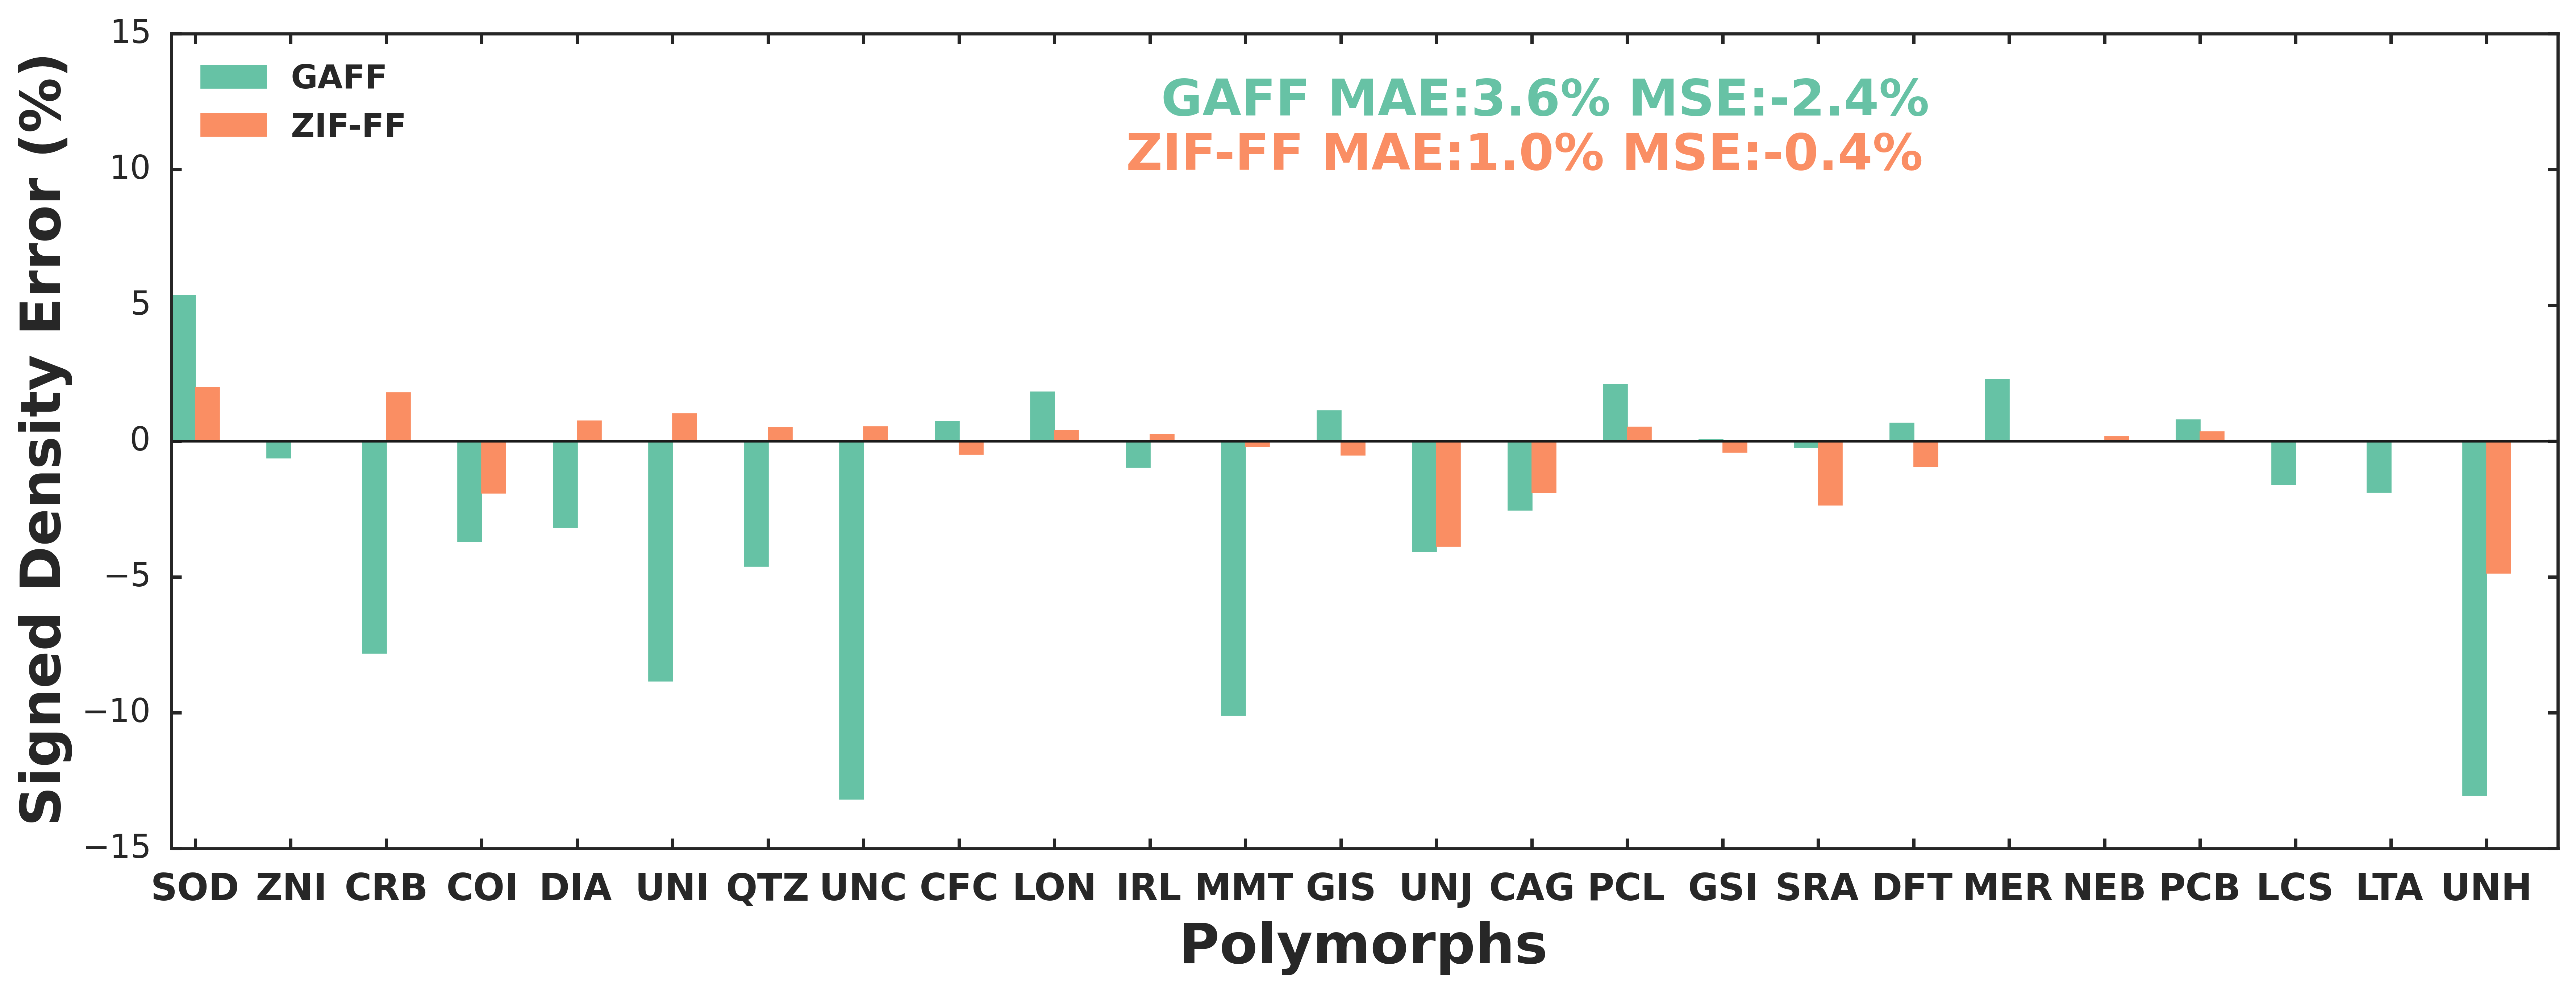

## Applications

Bond and Angle Distributions:
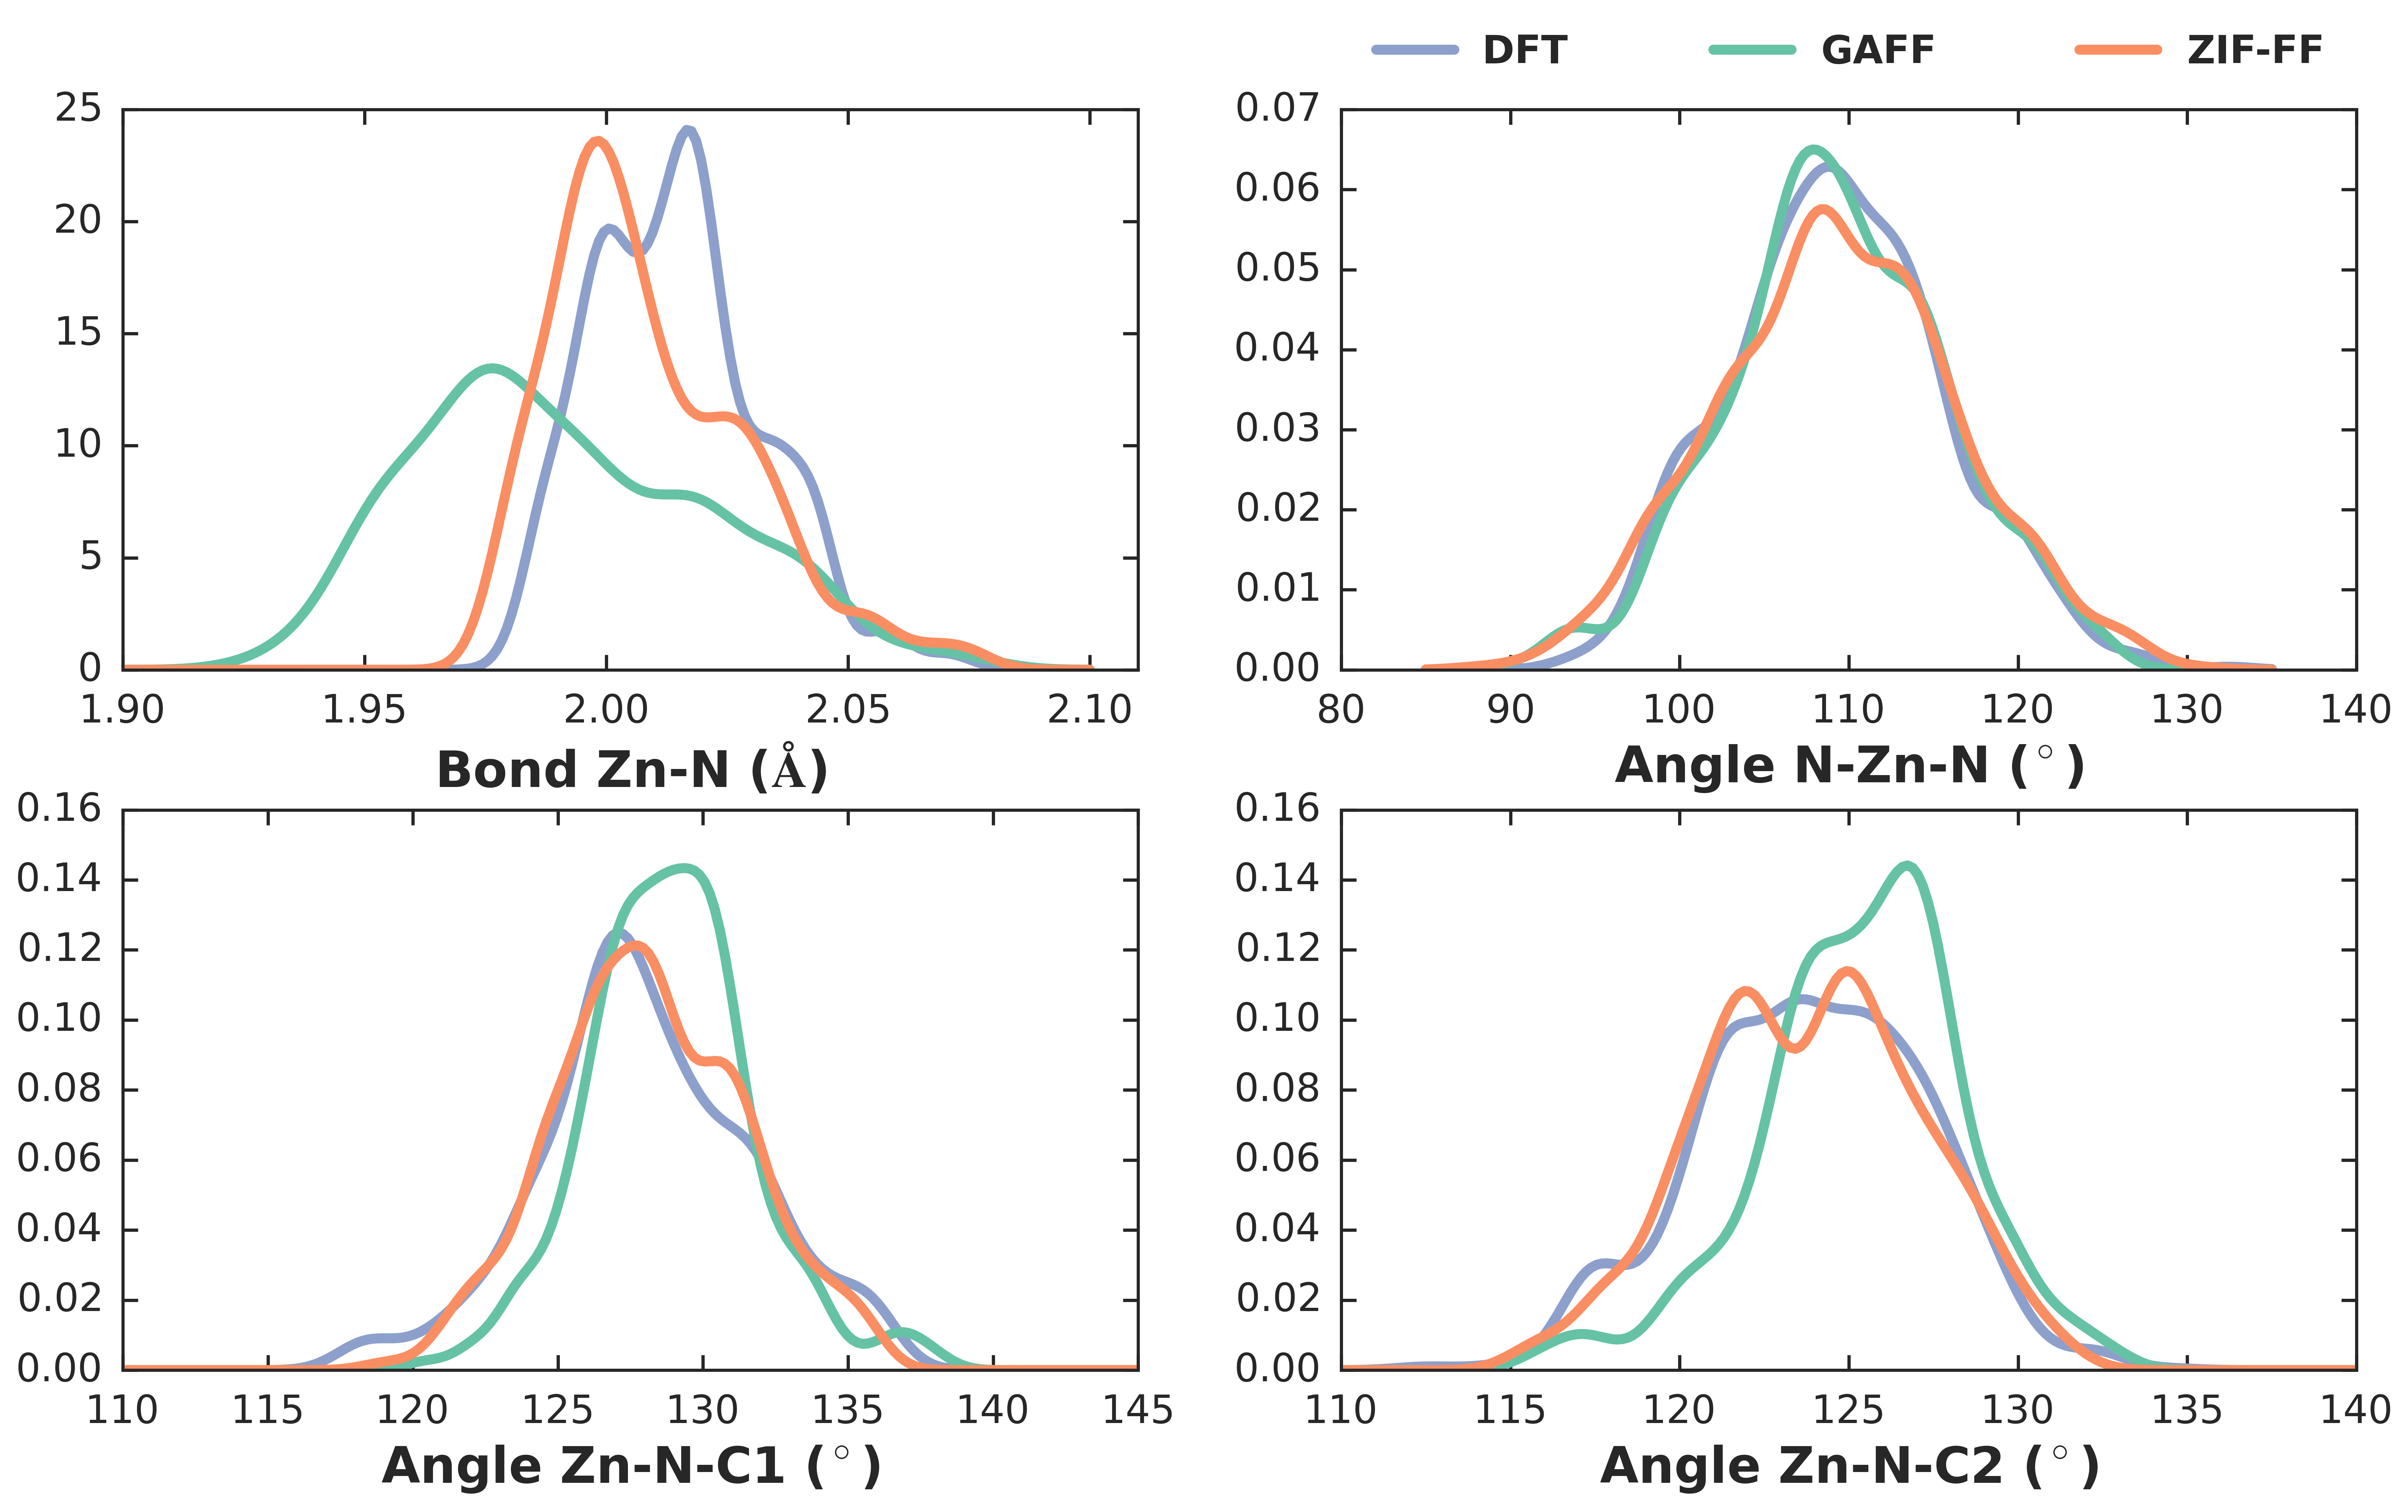
Phonon Density of States:
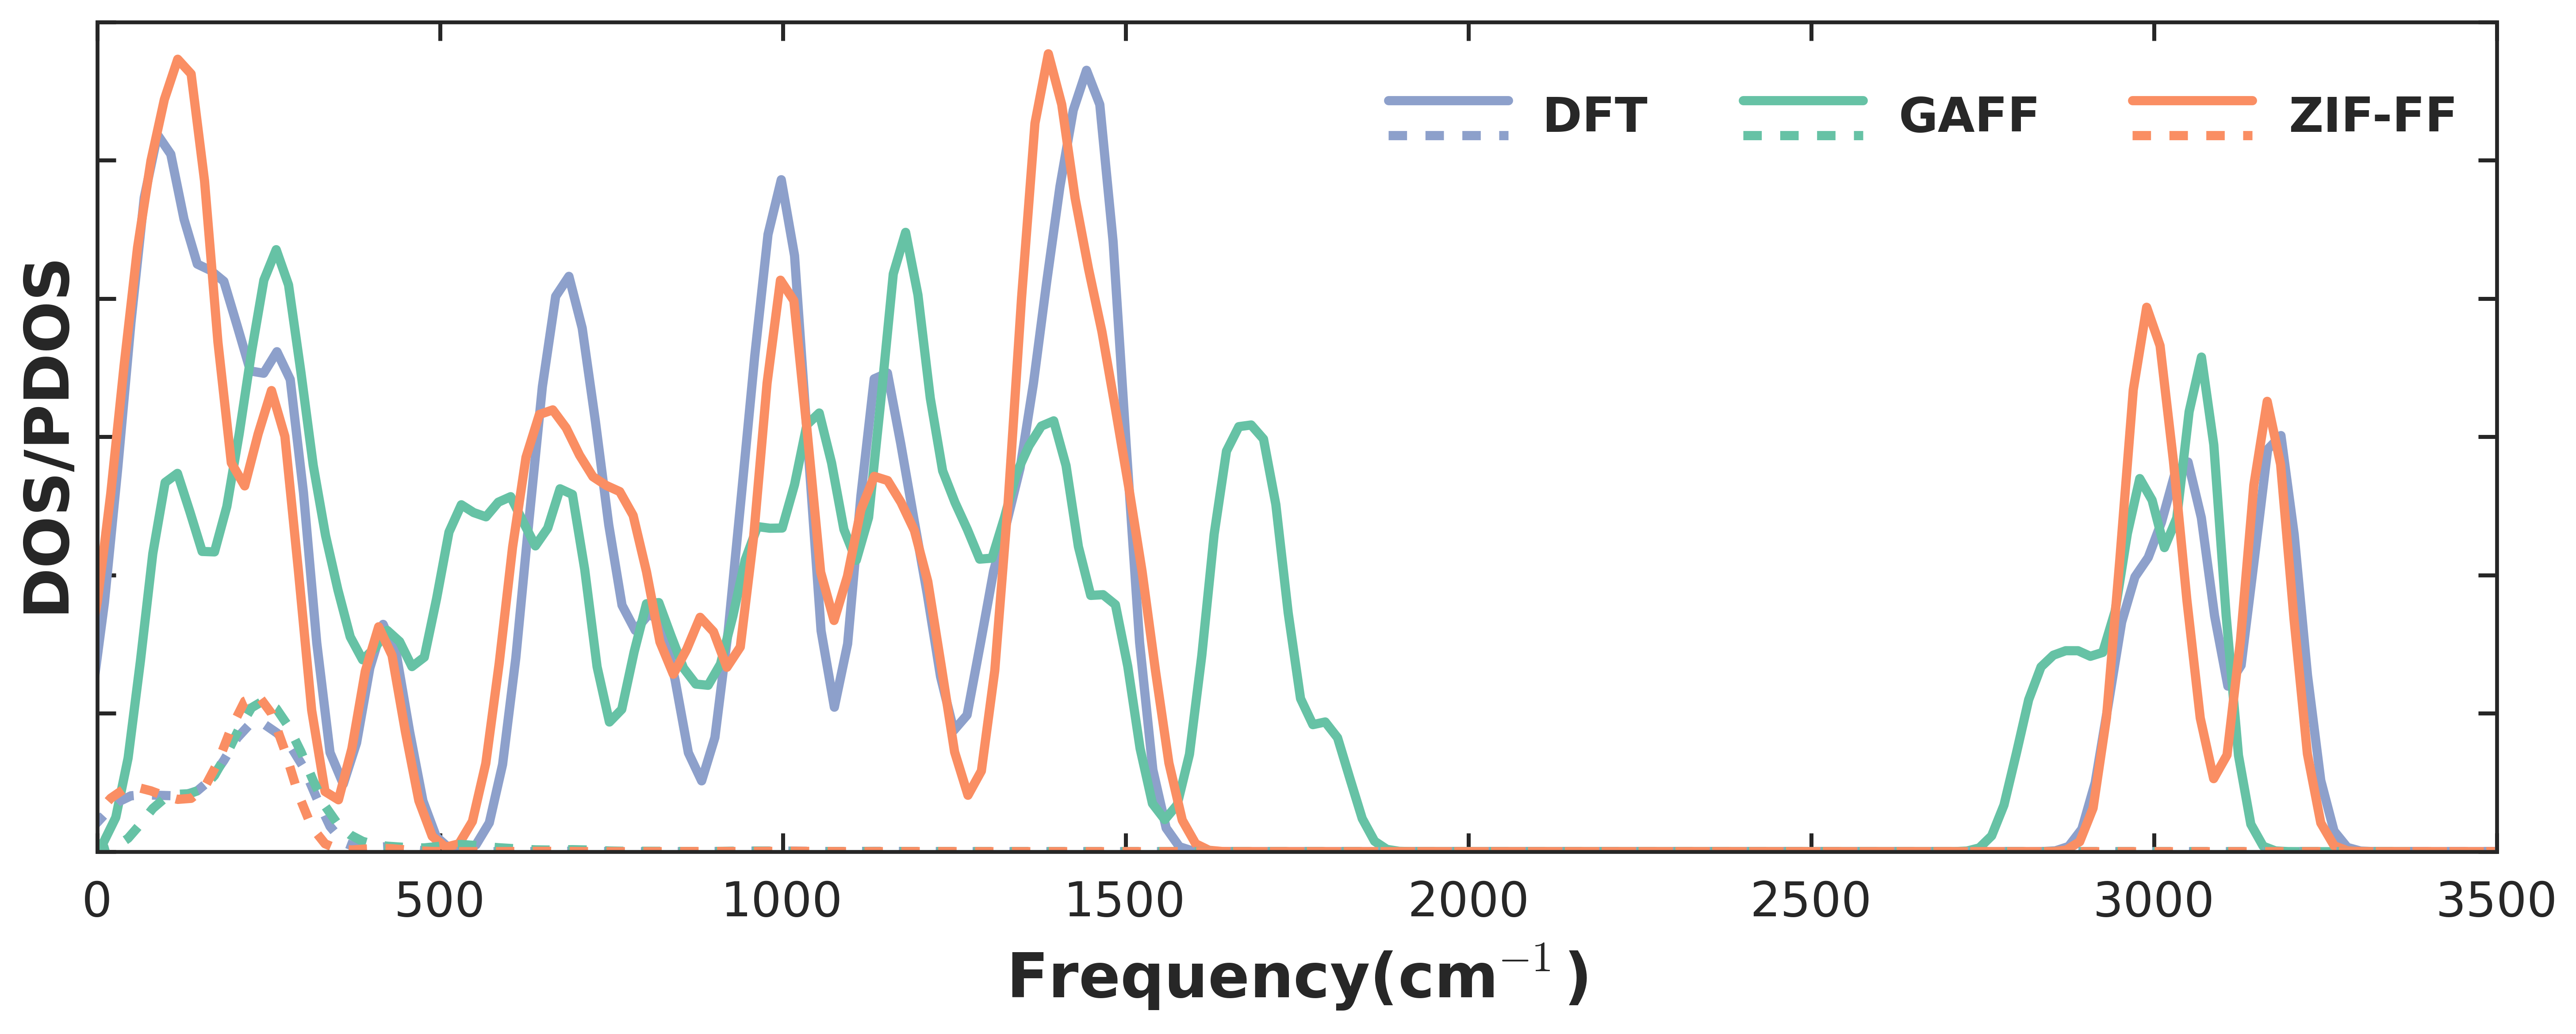
Methane Diffusion:
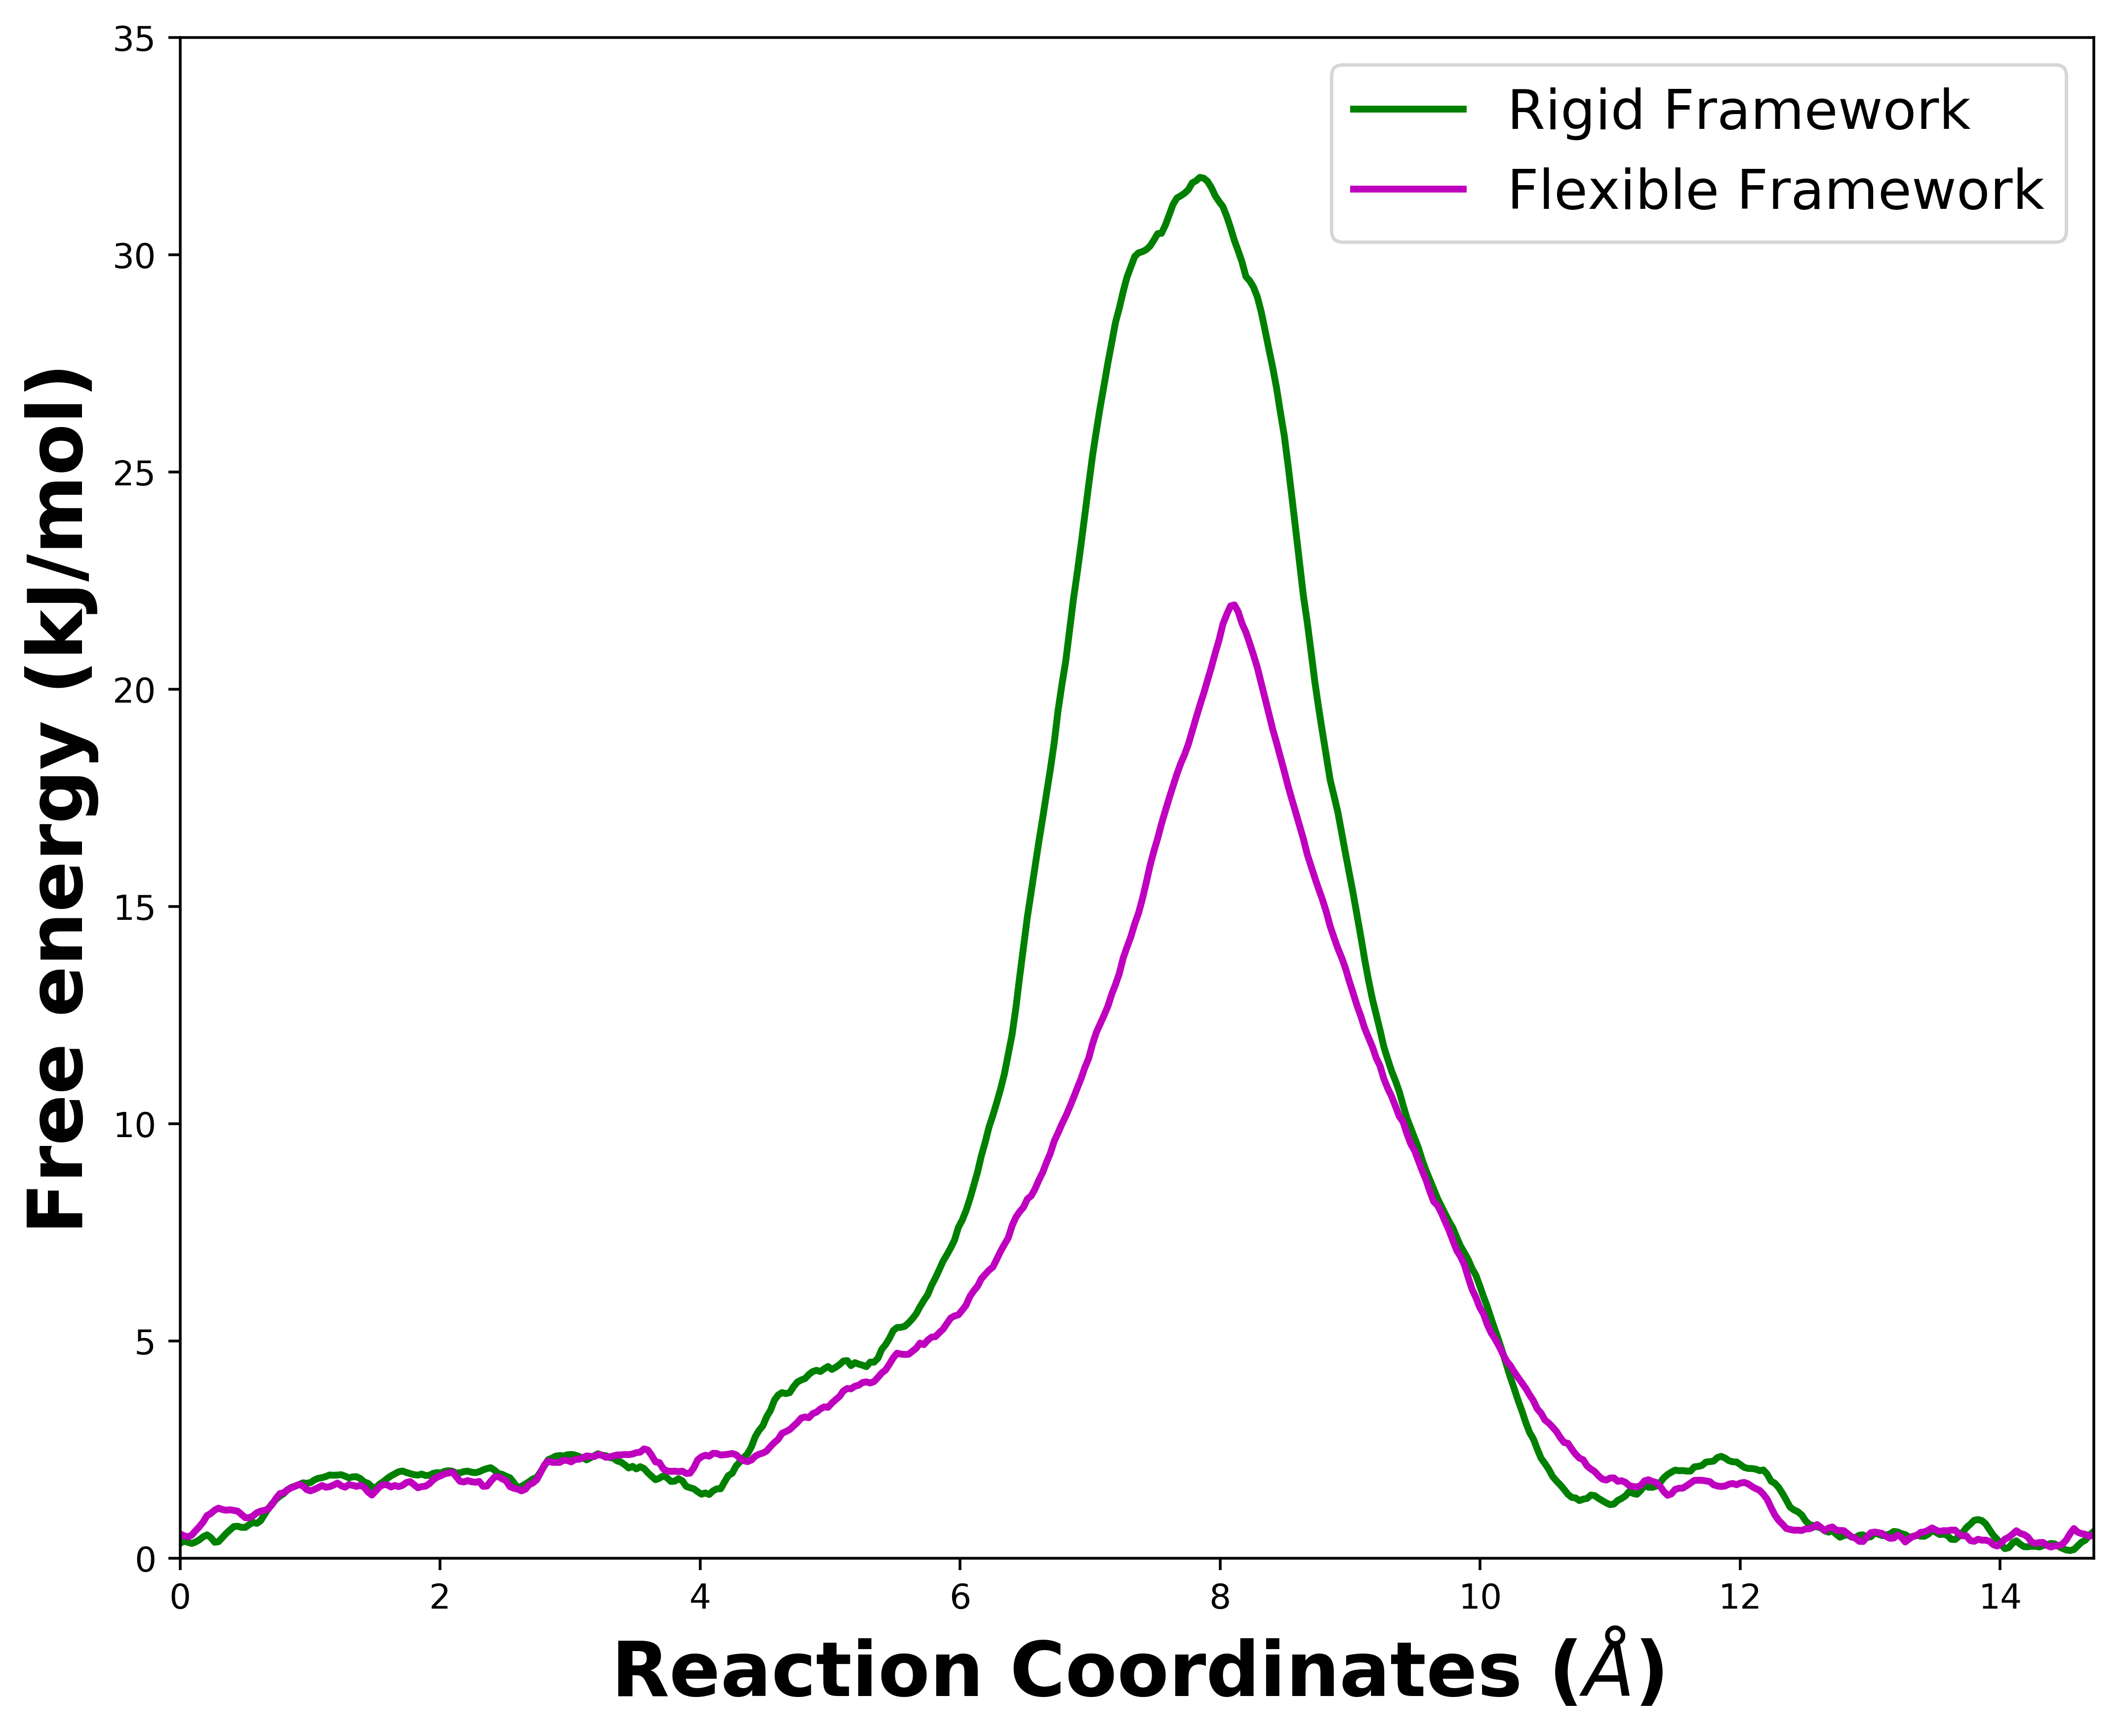
Structure Factor:
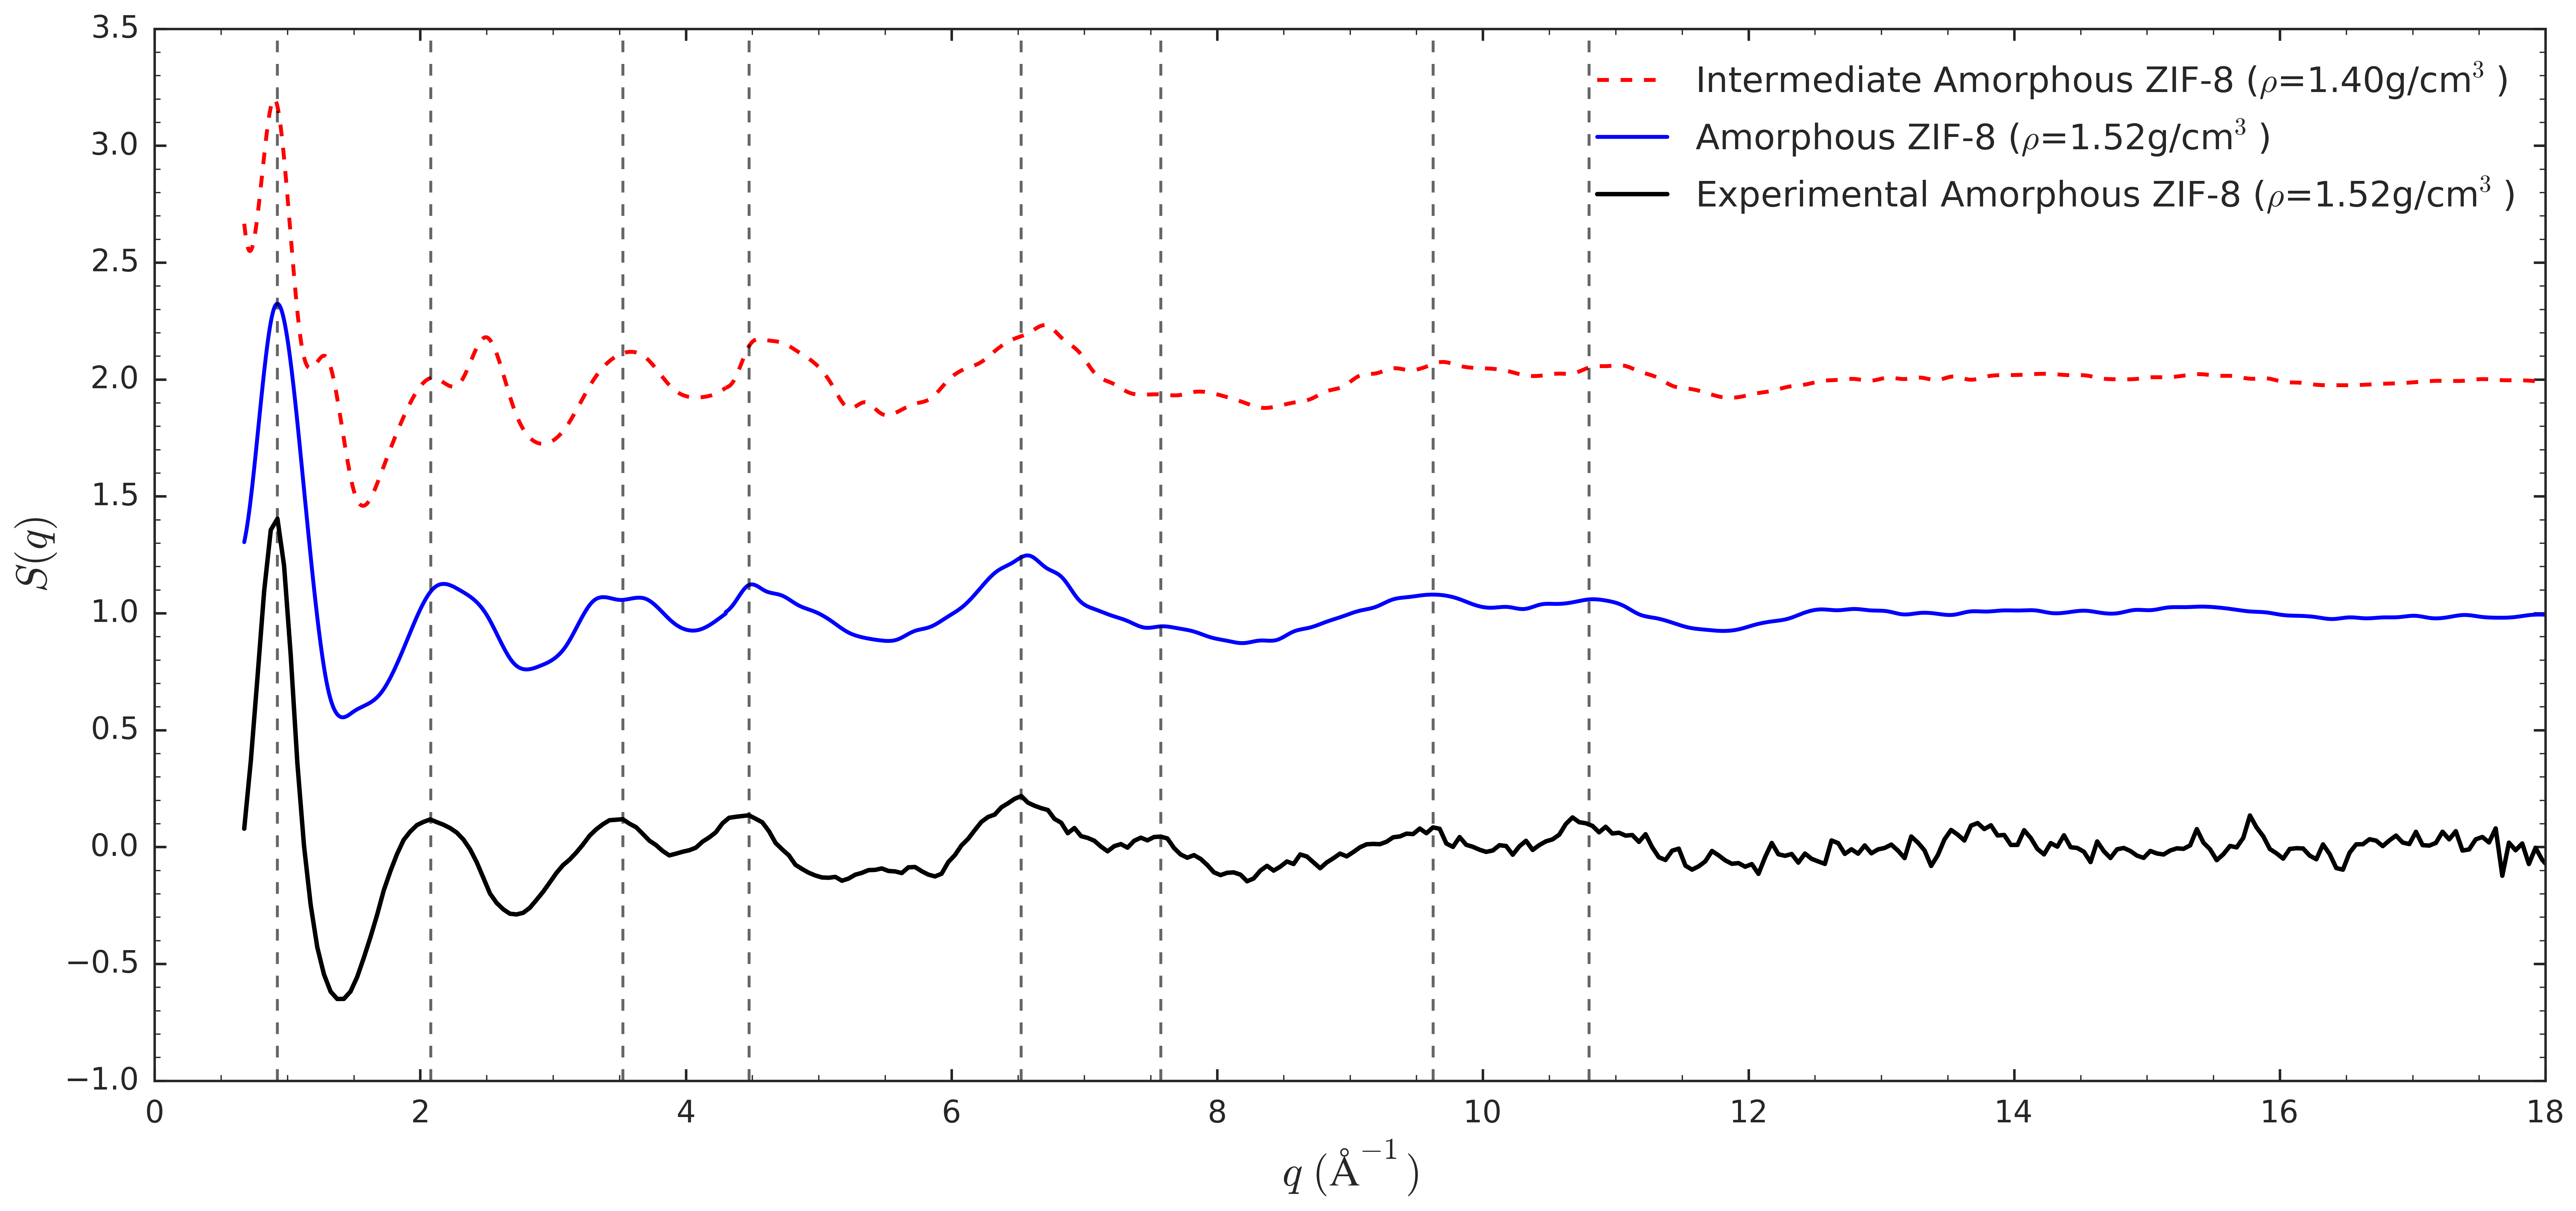

## Tansferability